## Bayesian mixture

# Intuition

**FIGURE PLACEHOLDER:** ![Bayesian mixture](image_placeholder)

# Notation


## Mixture

A mixture model is a statistical model that represents the data as coming from a mixture of two or more underlying distributions. These models are particularly useful when the data may be generated by different processes or subgroups, but we don't have direct information about which subgroup each data point belongs to. In a mixture model, we assume that the observed data are generated from a weighted sum of these different distributions, where each distribution corresponds to a different "component" in the mixture. The probability density function (PDF) of a mixture model can be written as:

$$
f(y_i) = \sum_{k=1}^{K} \pi_k f_k(y_i)
$$

Where:
- $f(y_i)$ is the overall probability density function of the data point $y_i$.
- $K$ is the number of components (distributions) in the mixture (e.g., two populations in our height example).
- $\pi_k$ is the **mixture weight** for the $k$-th component, which represents the proportion of data points from that component in the total population. These weights satisfy the condition:

$$
\sum_{k=1}^{K} \pi_k = 1
$$

- $f_k(y_i)$ is the probability density function of the $k$-th component distribution, which can be any distribution, such as normal, exponential, etc.

In the case of a **mixture of normal distributions**, the individual components can be described by normal distributions with means $\mu_k$ and variances $\sigma_k^2$. The overall mixture density is then:

$$
f(y_i) = \sum_{k=1}^{K} \pi_k \mathcal{N}(y_i | \mu_k, \sigma_k^2)
$$

Where:
- $\mathcal{N}(y_i | \mu_k, \sigma_k^2)$ is the probability density function of the normal distribution for the $k$-th component, with mean $\mu_k$ and variance $\sigma_k^2$.


# Example

## Mixture

In the context of our height example, where there are two populations (with and without the genetic effect), the mixture model for height can be written as:

$$
f(y_i) = \pi_1 \cdot \mathcal{N}(y_i | 170, 1^2) + \pi_2 \cdot \mathcal{N}(y_i | 180, 2^2)
$$

Where:
- $\mathcal{N}(y_i | 170, 1^2)$ is the normal distribution for Population 1 (without genetic effect) with mean 170 cm and standard deviation 1 cm.
- $\mathcal{N}(y_i | 180, 2^2)$ is the normal distribution for Population 2 (with genetic effect) with mean 180 cm and standard deviation 2 cm.
- $\pi_1 = 0.7$ and $\pi_2 = 0.3$ are the mixture proportions, representing the proportion of individuals in each population.

In [50]:
rm(list=ls())
set.seed(2)

# Simulate true mean and effect size for two populations
baseline_pop1 <- 170  # Population 1 mean (without genetic effect)
theta_true_pop1 <- 5  # True genetic effect theta for Population 1
sd_y_pop1 <- 5        # Standard deviation for Population 1

baseline_pop2 <- 180  # Population 2 mean (with genetic effect)
theta_true_pop2 <- 2  # True genetic effect theta for Population 2
sd_y_pop2 <- 10        # Standard deviation for Population 2

# Mixture proportions
pi_1 <- 0.7  # Population 1 proportion
pi_2 <- 1-pi_1

# generate data
n=5
n_pop1 = round(n * pi_1)
n_pop2 = round(n * pi_2)

# Simulate genotypes for two populations
genotype_pop1 <- sample(0:2, n_pop1, replace = TRUE)  # Genotypes for Population 1
genotype_pop2 <- sample(0:2, n_pop2, replace = TRUE)  # Genotypes for Population 2

# Simulate height values for two populations based on genotypes
height_values_pop1 <- rnorm(n_pop1, mean = baseline_pop1 + theta_true_pop1 * genotype_pop1, sd = sd_y_pop1)
height_values_pop2 <- rnorm(n_pop2, mean = baseline_pop2 + theta_true_pop2 * genotype_pop2, sd = sd_y_pop2)

# Combine the data for both populations
population_combined <- c(rep("1", n_pop1), rep("2", n_pop2))
genotype_combined <- c(genotype_pop1, genotype_pop2)
height_combined <- c(height_values_pop1, height_values_pop2)

# Create a data frame with the combined data
data_combined <- data.frame(population = population_combined, genotype = genotype_combined, height = height_combined)

# Display the combined simulated data
data_combined

population,genotype,height
<chr>,<int>,<dbl>
1,0,169.5987
1,2,180.6621
1,1,178.5398
1,1,173.8015
2,0,199.8447
2,0,178.6121


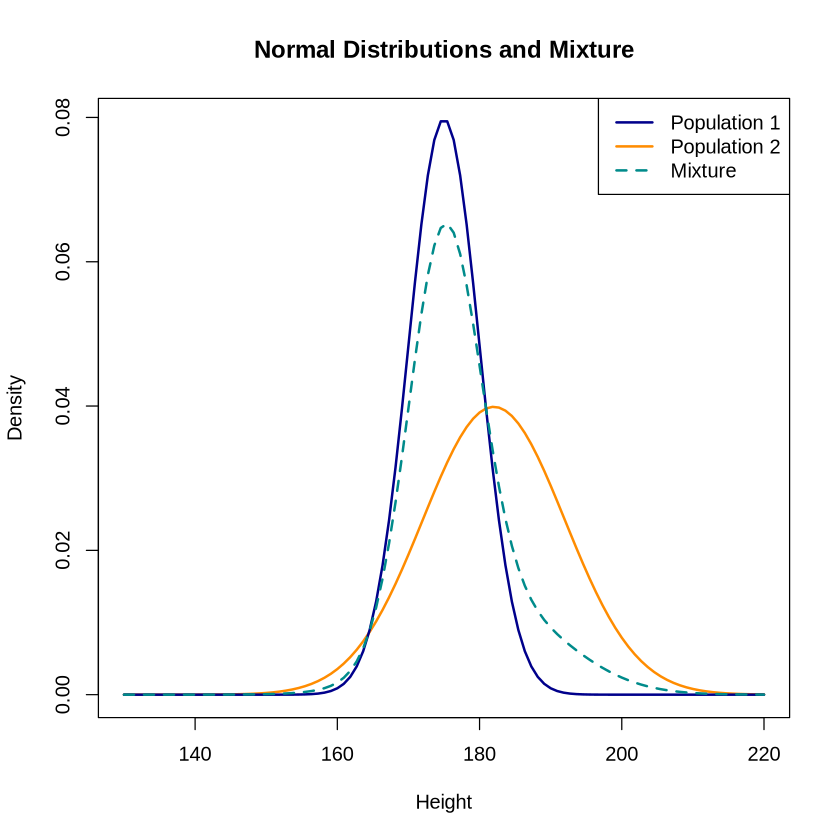

In [51]:
# Generate x values for visualization
x_values <- seq(130, 220, length.out = 100)

# Calculate the PDFs for both populations
pdf_pop1 <- dnorm(x_values, mean = baseline_pop1 + theta_true_pop1, sd = sd_y_pop1)
pdf_pop2 <- dnorm(x_values, mean = baseline_pop2 + theta_true_pop2, sd = sd_y_pop2)

# Mixture PDF (0.7 for Population 1 and 0.3 for Population 2)
pi_1 <- 0.7
pi_2 <- 1 - pi_1
pdf_mixture <- pi_1 * pdf_pop1 + pi_2 * pdf_pop2

# Calculate the maximum value across all PDFs for proper scaling
y_max <- max(c(pdf_pop1, pdf_pop2, pdf_mixture))

# Plot the PDFs for Population 1 and Population 2 with adjusted y-axis limits
plot(x_values, pdf_pop2, type = "l", col = "darkorange", lwd = 2,
     xlab = "Height", ylab = "Density", main = "Normal Distributions and Mixture", ylim = c(0, y_max))
lines(x_values, pdf_pop1, col = "darkblue", lwd = 2)
lines(x_values, pdf_mixture, col = "darkcyan", lwd = 2, lty = 2)  # Dashed line for the mixture

# Add a legend
legend("topright", legend = c("Population 1", "Population 2", "Mixture"),
       col = c("darkblue", "darkorange", "darkcyan"), lwd = 2, lty = c(1, 1, 2))


### Latent Variable Representation

The mixture model can also be expressed using latent variables, which represent the unobserved group membership of each data point. Let $z_i$ be the latent variable that indicates the group membership of individual $i$. We assume that:

$$
z_i = \begin{cases} 
1 & \text{if } y_i \text{ comes from Population 1} \\
2 & \text{if } y_i \text{ comes from Population 2}
\end{cases}
$$

The distribution of $y_i$ given $z_i$ is:

$$
f(y_i | z_i) = \mathcal{N}(y_i | \mu_{z_i}, \sigma_{z_i}^2)
$$

And the prior probability of $z_i$ (i.e., the probability of an individual belonging to Population 1 or Population 2) is given by the mixture proportions:

$$
P(z_i = 1) = \pi_1 \quad \text{and} \quad P(z_i = 2) = \pi_2
$$

Thus, the overall likelihood of the data under the mixture model can be expressed as:

$$
L(\pi_1, \pi_2, \mu_1, \mu_2, \sigma_1^2, \sigma_2^2 | D) = \prod_{i=1}^{n} \left( \pi_1 \mathcal{N}(y_i | \mu_1, \sigma_1^2) + \pi_2 \mathcal{N}(y_i | \mu_2, \sigma_2^2) \right)
$$

Where:
- $D = \{y_1, y_2, \dots, y_n\}$ is the set of observed data points.
- The parameters $\pi_1, \pi_2, \mu_1, \mu_2, \sigma_1^2, \sigma_2^2$ need to be estimated from the data, typically using methods such as **Maximum Likelihood Estimation (MLE)** or **Bayesian Inference**.

TODO